# Tutorial: Turn Detection

**Author:** Masoud Abedinifar

**Last update:** Wed 02 October 2024

## Learning Objectives
By the end of this tutorial:

- You can load data from [`keepcontrol`](https://github.com/neurogeriatricskiel/KielMAT/blob/main/kielmat/datasets/keepcontrol.py) which is one of available datasets.
- Apply the [`Pham Turn Detection`](https://github.com/neurogeriatricskiel/KielMAT/blob/main/kielmat/modules/td/_pham.py) algorithm.
- Visualize the results of the algorithm.
- Extract spatio-temporal parameters of the detected turns.
- Interpret the detected turns for further analysis.

# Pham Turn Detection

This example can be referenced by citing the package.

The example illustrates how to use PhamTurnDetection algorithm to detect turns using acceleration and gyro data recorded with a lower back IMU sensor. The turn detection algorithm is implemented using [`kielmat.modules.td._pham`](https://github.com/neurogeriatricskiel/KielMAT/blob/main/kielmat/modules/td/_pham.py). This algorithm is based on the research of Pham et al [`1`].

This algorithm aims to detect turns using accelerometer and gyroscope data collected from a lower back inertial measurement unit (IMU) sensor. The core of the algorithm lies in the detect method, where turns are identified using accelerometer and gyroscope data. The method first processes the gyro data, converting it to rad/s and computing the variance to identify periods of low variance, which may indicate bias. It then calculates the gyro bias and subtracts it from the original gyro signal to remove any biases. Next, the yaw angle is computed by integrating the gyro data, and zero-crossings indices are found to detect turns. Then, turns are identified based on significant changes in the yaw angle.

The algorithm also accounts for hesitations, which are brief pauses or fluctuations in the signal that may occur within a turn. Hesitations are marked based on specific conditions related to the magnitude and continuity of the yaw angle changes.

Then, the detected turns are characterized by their onset and duration. Turns with angles equal to or greater than 90 degrees and durations between 0.5 and 10 seconds are selected for further analysis. Finally, the detected turns along with their characteristics (onset, duration, etc.) are stored in a pandas DataFrame (`turns_` attribute).

In addition, spatial-temporal parameters are calculated using detected turns and their characteristics by the `spatio_temporal_parameters` method. As a return, the turn id along with its spatial-temporal parameters including direction (left or right), angle of turn and peak angular velocity are stored in a pandas DataFrame (`parameters_` attribute).

Optionally, if `plot_results` is set to True, the algorithm generates a plot visualizing the accelerometer and gyroscope data alongside the detected turns. This visualization aids in the qualitative assessment of the algorithm's performance and provides insights into the dynamics of the detected turns.

#### References
[`1`] Pham et al. (2017). Algorithm for Turning Detection and Analysis Validated under Home-Like Conditions in Patients with Parkinson's Disease and Older Adults using a 6 Degree-of-Freedom Inertial Measurement Unit at the Lower Back. Frontiers in Neurology, 8, 135. https://doi.org/10.3389/fneur.2017.00135

## Import Libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset and PhamTurnDetection turn detection algortihm are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the `kielmat` library and its dependencies if you haven't already.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from kielmat.datasets import keepcontrol
from kielmat.modules.td import PhamTurnDetection
from pathlib import Path

## Data Preparation

To implement Pham Turn Detection algorithm, we load example data.


In [2]:
# Dataset path
dataset_path = Path(os.getcwd()) / "_keepcontrol"

# Fetch the dataset
keepcontrol.fetch_dataset(dataset_path)

In [3]:
# In this example, we use "imu" as tracking_system and "pelvis" as tracked points.
tracking_sys = "imu"
tracked_points = {tracking_sys: ["pelvis"]}

In [4]:
# The 'keepcontrol.load_recording' function is used to load the data from the specified file_path
recording = keepcontrol.load_recording(
    dataset_path=dataset_path,
    id="pp002",
    task="tug",
    tracking_systems=[tracking_sys], 
    tracked_points=tracked_points
)

In [5]:
# Load lower back acceleration data
accel_data = recording.data[tracking_sys][
    ["pelvis_ACCEL_x", "pelvis_ACCEL_y", "pelvis_ACCEL_z"]
]

# Get the acceleration data unit from the recording
accel_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("ACCEL", case=False)
]["units"].iloc[0]

# Print acceleration data
print(f"accel_data ({accel_unit}): {accel_data}")

accel_data (g):       pelvis_ACCEL_x  pelvis_ACCEL_y  pelvis_ACCEL_z
0           0.920901       -0.047850       -0.400888
1           0.919441       -0.051282       -0.392583
2           0.922828       -0.047359       -0.392093
3           0.926741       -0.048830       -0.384279
4           0.918973       -0.053218       -0.397947
...              ...             ...             ...
2903        0.966803       -0.027822       -0.279782
2904        0.957517       -0.035152       -0.285636
2905        0.960437       -0.034171       -0.291979
2906        0.962890       -0.036623       -0.299794
2907        0.963883       -0.038584       -0.294921

[2908 rows x 3 columns]


In [6]:
# Load lower back gyro data
gyro_data = recording.data[tracking_sys][
    ["pelvis_GYRO_x", "pelvis_GYRO_y", "pelvis_GYRO_z"]
]

# Get the gyro data unit from the recording
gyro_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("GYRO", case=False)
]["units"].iloc[0]

# Print gyro data
print(f"gyro_data ({gyro_unit}): {gyro_data}")

gyro_data (deg/s):       pelvis_GYRO_x  pelvis_GYRO_y  pelvis_GYRO_z
0          0.000000      -0.614677       0.436291
1          0.000000      -0.700049       0.176093
2         -0.172905      -0.261807      -0.262826
3          0.262815      -0.261807       0.000000
4          0.608625      -0.614677      -0.349559
...             ...            ...            ...
2903      -0.089911      -1.309034       0.000000
2904       0.525631      -0.438242      -0.436291
2905       0.871441      -0.961855       0.086733
2906       1.051262      -0.700049       0.176093
2907       1.134256      -0.347179      -0.525652

[2908 rows x 3 columns]


In [7]:
# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "pelvis_ACCEL_x"
]["sampling_frequency"].values[0]

# Print sampling frequency
print(f"sampling frequency: {sampling_frequency} Hz")

sampling frequency: 200 Hz


#### Data Units and Conversion to SI Units

All input data provided to the modules in this toolbox should adhere to SI units to maintain consistency and accuracy across analyses. This ensures compatibility with the underlying algorithms, which are designed to work with standard metric measurements.

If any data is provided in non-SI units (e.g., acceleration in g instead of m/s²), it is needed that the data to be converted into the appropriate SI units before using it as input to the toolbox. Failure to convert non-SI units may lead to incorrect results or misinterpretation of the output.

For instance:

- **Acceleration:** Convert from g to m/s².

In [8]:
# Check unit of acceleration data
if accel_unit in ["m/s^2"]:
    pass  # No conversion needed
elif accel_unit in ["g", "G"]:
    # Convert acceleration data from "g" to "m/s^2"
    accel_data *= 9.81
    # Update unit of acceleration
    accel_unit = ["m/s^2"]

# Check unit of gyro data
if gyro_unit in ["deg/s", "°/s"]:
    pass  # No conversion needed
elif gyro_unit == "rad/s":
    # Convert gyro data from "rad/s" to "deg/s"
    gyro_data = np.rad2deg(gyro_data)
    # Update unit of gyro
    gyro_unit = ["deg/s"]

## Visualisation of the Data
The raw acceleration and gyro data including components of x, y and z axis are plotted.

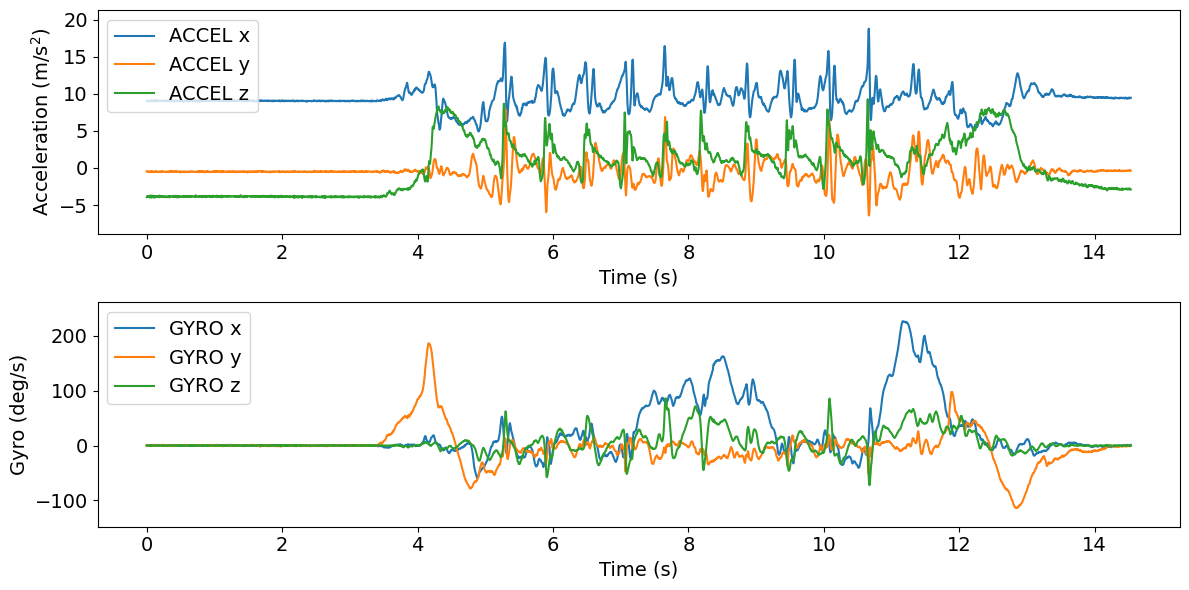

In [9]:
# Plot acceleration and gyro in subplots
fig = plt.figure(figsize=(12, 6))

# Subplot 1: ACCEL data
ax1 = plt.subplot(211)
for i in range(3):
    ax1.plot(
        np.arange(len(accel_data)) / sampling_frequency,
        accel_data[f"pelvis_ACCEL_{chr(120 + i)}"],
        label=f"ACCEL {'xyz'[i]}",
    )
ax1.set_ylabel(f"Acceleration (m/s$^{2}$)", fontsize=14)
ax1.set_xlabel(f"Time (s)", fontsize=14)
ax1.legend(loc="upper left", fontsize=14)
accel_min = np.min(accel_data)
accel_max = np.max(accel_data)
buffer = (accel_max - accel_min) * 0.1
ax1.set_ylim(accel_min - buffer, accel_max + buffer)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2: GYRO data
ax2 = plt.subplot(212)
for i in range(3):
    ax2.plot(
        np.arange(len(gyro_data)) / sampling_frequency,
        gyro_data[f"pelvis_GYRO_{chr(120 + i)}"],
        label=f"GYRO {'xyz'[i]}",
    )
ax2.set_ylabel(f"Gyro (deg/s)", fontsize=14)
ax2.set_xlabel(f"Time (s)", fontsize=14)
ax2.legend(loc="upper left", fontsize=14)
gyro_min = np.min(gyro_data)
gyro_max = np.max(gyro_data)
buffer = (gyro_max - gyro_min) * 0.1
ax2.set_ylim(gyro_min - buffer, gyro_max + buffer)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
plt.show()

## Applying Pham Turn Detection Algorithm
Now, we are running Pham turn detection algorithm from pham module [`PhamTurnDetection`](https://github.com/neurogeriatricskiel/KielMAT/blob/main/kielmat/modules/td/_pham.py) to detect turns.

The following code first prepares the input data by combining acceleration and gyro data into a single DataFrame called `input_data`.

Then, in order to apply turn detection algorithm, an instance of the PhamTurnDetection class is created using the constructor, `PhamTurnDetection()`. The `pham` variable holds this instance, allowing us to access its methods. The inputs of the algorithm are as follows:

- **Acceleration data:** `accel_data (pd.DataFrame)` includes accelerometer data (N, 3) for x, y, and z axes. in pandas Dataframe format. The unit of acceleration data should be in SI as m/s².
- **Gyro data:** `gyro_data (pd.DataFrame)` includes gyro data (N, 3) for x, y, and z axes. in pandas Dataframe format. The unit of Gyro data should be in deg/s.
- **Vertical gyro:** `gyro_vertical (str)` corresponds to the name of the vertical component of gyro.
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz.
- **Datetime:** `dt_data (pd.Series, optional)` is the original datetime in the input data which is optional.
- **Tracking system:** `tracking_system (str, optional)` is the name of tracking system which is optional.
- **Tracked Point:** `tracked_point (str, optional)` is the tracked point name on the body which is optional.
- **Plot Results:** `plot_results (bool, optional)`, if set to True, generates a plot showing the detected turns on the data. The default is False. The onset is represented with the vertical red line and the grey area represents the duration of the turns detected by the algorithm.

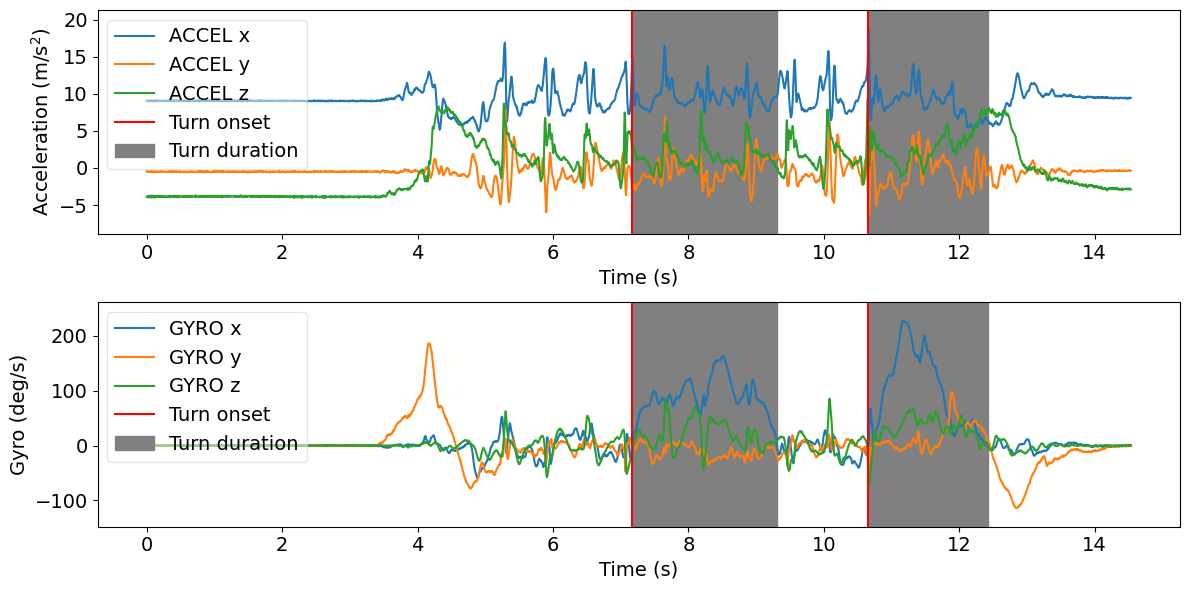

In [10]:
# Create an instance of the PhamTurnDetection class
pham = PhamTurnDetection()

# Call the turn detection using pham.detect
pham = pham.detect(
    accel_data=accel_data,
    gyro_data=gyro_data,
    gyro_vertical="pelvis_GYRO_x",
    sampling_freq_Hz=sampling_frequency,
    tracking_system="imu",
    tracked_point="pelvis",
    plot_results=True,
)

The outputs are stored in the `turns_` attribute, which is a pandas DataFrame in BIDS format with the following columns:

- **onset**: Start of the turn event in seconds.
- **duration**: Duration of the turn event in seconds.
- **event_type**: Type of event which is turn.
- **tracking_systems**: Tracking system which is 'imu' for this example.
- **tracked_points**: Tracked points on the body which is 'pelvis' for this example.

In [11]:
# Print events and their corresponding information
print(f"turn events: {pham.turns_}")

turn events:    onset  duration event_type tracking_systems tracked_points
0   7.17     2.140       turn              imu         pelvis
1  10.65     1.775       turn              imu         pelvis


## Extraction of Spatio-temporal Parameters

Next, the spatial-temporal parameters could be extracted using the spatio_temporal_parameters method. The outputs are stored in the `parameters_` attribute, which is a pandas DataFrame and icnlues trun id along with the following parameters:

- **direction_of_turn**: Direction of turn which is either "left" or "right".
- **angle_of_turn**: Angle of turn in degrees.
- **peak_angular_velocity**: Peak angular velocity in deg/s.


In [12]:
# Call the spatio-temporal parameters object for extracting the temporal parameters
pham.spatio_temporal_parameters()

# Print temporal parameters for each turn
print(pham.parameters_)

        direction_of_turn  angle_of_turn  peak_angular_velocity
turn id                                                        
0                   right     191.670638             162.252753
1                   right     175.474290             226.296714
